<a href="https://colab.research.google.com/github/cbedart/S-DISCO/blob/main/S_DISCO_Integrated_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<center><h1>S-DISCO - Integrated approaches</h1></center>**



---



# <font color='#FF7777'><b>Before anything else:</b></font>

**<font color='#FF7777'>In "Connect > Change runtime type", change your hardware accelerator to "T4 GPU". </font>**As you will need to use a GPU to speed up your calculations, you will need to ask Google to allocate a GPU to the Colab session.


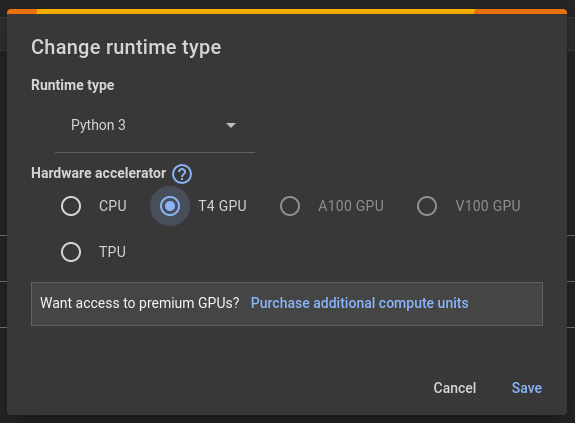

# Prerequisites

In [ ]:
# @title Installation of prerequisites

################################################################################

try:
  installed
except:
  installed = 0

if installed == 0:
  !wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina
  !chmod +x gnina
  !pip install py3Dmol
  !apt install openbabel
  !pip3 install rdkit
  installed = 1
else:
  print("Already installed")

################################################################################

import os, sys
import pandas as pd
import numpy as np

from google.colab import files

import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider
from IPython.display import Image, display, clear_output, Javascript, HTML

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import pydotplus

# import binana
import py3Dmol

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors, rdFingerprintGenerator, Draw, PandasTools, QED
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
RDLogger.DisableLog('rdApp.*')

from sklearn import preprocessing, decomposition, datasets, tree
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, LeaveOneOut

import warnings
warnings.filterwarnings('ignore')

################################################################################

print("\n\n\033[1mPrerequisites succesfully installed !\033[0m")

In [ ]:
# @title Python main functions
################################################################################

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

################################################################################

def tree_graph_to_png(tree, feature_names, class_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, class_names=class_names,
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

################################################################################

def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

################################################################################

def elimcor_sansY(X, s=0.95):
    correl = np.corrcoef(X, rowvar=False)
    stop = False
    possetap = list(range(X.shape[1]))
    groupes = {i: [i] for i in range(X.shape[1])}

    while not stop:
        # Regroup variables for which |corr| > threshold
        gplist = {}
        possglob = list(range(correl.shape[0]))
        for i in range(correl.shape[0]):
            poss = possglob[:i] + possglob[i+1:]
            gplist[i] = [i] + [poss[j] for j in range(len(poss)) if abs(correl[i, poss[j]]) > s]

        # Sort groups from largest to smallest
        gplisteff = {k: len(v) for k, v in gplist.items()}
        if any(val > 1 for val in gplisteff.values()):
            gplistfin = {k: v for k, v in gplist.items() if gplisteff[k] > 1}
            gplistuniq = [k for k, v in gplisteff.items() if v == 1]
            gpsel = []
            for i in gplistfin.values():
                selloc = min(i)
                gploc = groupes[possetap[selloc]]
                for j in i:
                    gploc.extend(groupes[possetap[j]])
                groupes[possetap[selloc]] = list(set(gploc))
                gpsel.append(selloc)
            possetap = [val for idx, val in enumerate(possetap) if idx in gplistuniq or val in set(gpsel)]
            correl = np.corrcoef(X.iloc[:,possetap], rowvar=False)
        else:
            stop = True

    return {"possetap": possetap, "groups": list(groupes.values())}

################################################################################

def top3_poses(docked_sdf, rec="rec.pdb", lig="lig.pdb", display=display):
    ids = ["Pose #1", "Pose #2", "Pose #3"]
    supplier = Chem.SDMolSupplier(docked_sdf)
    molecules = [Chem.MolToMolBlock(mol) for mol in supplier if mol is not None]
    scores = [mol.GetProp("minimizedAffinity") for mol in supplier if mol is not None]

    lig_ref = Chem.MolFromPDBFile(lig)
    # rmsd = [AllChem.CalcRMS(lig_ref, mol, map=lig_ref.GetSubstructMatch(mol)) for mol in supplier if mol is not None]

    html_str = '''
    <table class="center">
    <tr>
    <td><h2 style="text-align:center;">{0}</h2></td>
    <td><h2 style="text-align:center;">{1}</h2></td>
    <td><h2 style="text-align:center;">{2}</h2></td>
    </tr>
    <tr>
    <td id="{0}">{3}</td>
    <td id="{1}">{4}</td>
    <td id="{2}">{5}</td>
    </tr>
    </table>
    '''

    html_str = html_str.format(ids[0], ids[1], ids[2], scores[0], scores[1], scores[2])
    display(HTML(html_str))

    for i in range(3):
        viewer = py3Dmol.view(width=400, height=400)
        viewer.addModel(open('rec.pdb').read())
        viewer.setStyle({'cartoon':{},'stick':{'radius':0.15}})
        viewer.addModel(open('lig.pdb').read())
        viewer.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
        viewer.addModel(molecules[i])
        viewer.setStyle({'model':2},{'stick':{'colorscheme':'cyanCarbon'}})
        viewer.zoomTo({'model':1})
        viewer.insert(ids[i])
    return

#####

def CB_Gnina_pandas(input_sdf, active):
    temp = PandasTools.LoadSDF(input_sdf)
    temp["minimizedAffinity"] = pd.to_numeric(temp["minimizedAffinity"])
    temp = temp.sort_values("minimizedAffinity").drop_duplicates("ID")
    temp.index = range(len(temp))

    temp["Active"] = active
    temp[["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts", "PAINS"]] = 0

    smiles_list = []
    for rowid_temp in range(len(temp)):
        smiles_list.append(Chem.MolToSmiles(temp.loc[rowid_temp,"ROMol"]))
        temp.loc[rowid_temp, ["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts"]] = [round(i,2) for i in QED.properties(temp["ROMol"][rowid_temp])]

    temp["ROMol"] = smiles_list
    return temp


#####

def CB_AUC(data_x, data_y):
    calculated_auc = 0
    for i in range(len(data_x)-1):
        auc_temp = (data_y[i] + data_y[i+1]) * (data_x[i+1] - data_x[i]) / 2
        calculated_auc = calculated_auc + auc_temp
    return calculated_auc

################################################################################

print("\033[1mFunctions succesfully loaded !\033[0m")

In [ ]:
# @title Download/load data
################################################################################

!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_input_subset.pkl
!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_topredict_subset.pkl

!wget -nc https://github.com/cbedart/S-DISCO/raw/main/results_cah2_docking.pkl
!wget -nc https://github.com/cbedart/S-DISCO/raw/main/CAH2_1BCD_prep.mol2
!wget -nc https://github.com/cbedart/S-DISCO/raw/main/conf.txt

!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_input_desc_noNA.pkl
!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_input_fps_noNA.zip
!unzip -u cah2_input_fps_noNA.zip

!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_topredict_input_desc_noNA.pkl
!wget -nc https://github.com/cbedart/S-DISCO/raw/main/cah2_topredict_input_fps_noNA.pkl

cah2_input_subset = pd.read_pickle("cah2_input_subset.pkl")
cah2_topredict_subset = pd.read_pickle("cah2_topredict_subset.pkl").sort_values("Name")
cah2_input_desc_noNA = pd.read_pickle("cah2_input_desc_noNA.pkl")
cah2_input_fps_noNA = pd.read_pickle("cah2_input_fps_noNA.pkl")
cah2_topredict_input_desc_noNA = pd.read_pickle("cah2_topredict_input_desc_noNA.pkl")
cah2_topredict_input_fps_noNA = pd.read_pickle("cah2_topredict_input_fps_noNA.pkl")

results_cah2_temp = pd.read_pickle("results_cah2_docking.pkl")
results_cah2_VA = results_cah2_temp["VA"]
results_cah2_CS = results_cah2_temp["CS"]
results_cah2_CA = results_cah2_temp["CA"]
results_cah2_VS = results_cah2_temp["VS"]

# Data presentation

**Protein** = Carbonic Anhydrase II (CAH2)  
**UniProt ID** = <a href="https://www.uniprot.org/uniprotkb/P00918/entry">P00918</a>  
**PDB ID** = <a href="https://www.rcsb.org/structure/1BCD">1BCD</a>  
<br />
**Retrospective virtual screening data** = <a href="https://dude.docking.org/targets/cah2">DUD-E subset with 492 active ligands and 31,172 decoys</a>  
**QSAR/Machine learning data** = <a href="https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL205/">CHEMBL205</a>  
<br />
**Main objectives of the practical session:**
* 4 different ligands assigned to each person, with a subset ID between 1 and 8 (so be sure to use your own ID).
* At least one "active" (Ki < 10nM), at least one "inactive" (Ki > 250nM).
* Using the various methods covered in the previous sessions, describe whether your ligands can be considered active or inactive.
* If your only argument is to look at the data available on the internet, it's automatically the worst grading possible. We want you to give us rational thought and descriptions, even if nothing works and you identify everything as inactive or active.


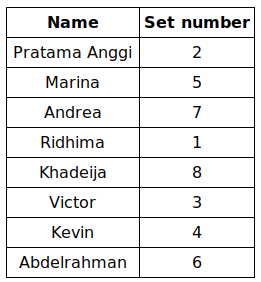

In [ ]:
# @markdown <b><font color="#FF7777">Please setup your subsetID below:</font></b>

subsetID = 0 # @param [0,1,2,3,4,5,6,7,8] {type:"raw"}

if subsetID == 0:
  print("Your subset is not properly defined - Change it")
else:
  cah2_topredict_group = cah2_topredict_subset[cah2_topredict_subset["Group"] == subsetID]
  cah2_topredict_group.index = range(len(cah2_topredict_group))
  display(cah2_topredict_group)

  display(Draw.MolsToGridImage([Chem.MolFromSmiles(cah2_topredict_group["Smiles"].loc[i]) for i in range(len(cah2_topredict_group))],molsPerRow=4,subImgSize=(200,200),legends=cah2_topredict_group["Name"].to_list()))

# <b><font color="#FF7777"> Virtual screening using Gnina </b></font>

In [ ]:
# @title <b>Retrospective docking</b>

# @markdown Total of <b>31,569</b> compounds with <b>492</b> active compounds and <b>31,077</b> decoys.
top_percent = 0.5 # @param {type:"slider", min:0.1, max:5, step:0.1}
xlog_scale = True # @param {type:"boolean"}

nb_actives = results_cah2_VA.value_counts("Active")[1]
enrich_VA = [0] + list(results_cah2_VA.sort_values("minimizedAffinity", ascending=True)["Active"].cumsum() / nb_actives)
enrich_CS = [0] + list(results_cah2_CS.sort_values("CNNscore", ascending=False)["Active"].cumsum() / nb_actives)
enrich_CA = [0] + list(results_cah2_CA.sort_values("CNNaffinity", ascending=False)["Active"].cumsum() / nb_actives)
enrich_VS = [0] + list(results_cah2_VS.sort_values("CNN_VS", ascending=False)["Active"].cumsum() / nb_actives)

enrich_random = [i/nb_actives for i in np.linspace(0,nb_actives,len(results_cah2_VA)+1)]
enrich_perfect = [i/nb_actives for i in list(range(0,nb_actives+1)) + list(np.repeat(nb_actives,len(results_cah2_VA)-nb_actives))]

enrich_xaxis = np.linspace(0, 1, len(enrich_VA))

plt.figure(figsize=[12,7])
plt.title("Enrichment curve - Retrospective docking")

# retrospective_colors = ["#FFD166", "#EF476F", "#F78C6B", "#06D6A0", "#118AB2", "#073B4C"]
retrospective_colors = ["gold", "red", "#F78C6B", "#06D6A0", "#118AB2", "#073B4C"]

plt.plot(enrich_xaxis, enrich_perfect, color = retrospective_colors[0], linewidth=2)
plt.plot(enrich_xaxis, enrich_random, color = retrospective_colors[1], linewidth=2)

plt.plot(enrich_xaxis, enrich_VA, color = retrospective_colors[2], linewidth=2)
plt.plot(enrich_xaxis, enrich_CS, color = retrospective_colors[3], linewidth=2)
plt.plot(enrich_xaxis, enrich_CA, color = retrospective_colors[4], linewidth=2)
plt.plot(enrich_xaxis, enrich_VS, color = retrospective_colors[5], linewidth=2)

leg = plt.legend(["Perfect", "Random", "Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"])
for line in leg.get_lines():
    line.set_linewidth(5)

plt.xlabel("%database (False Positive Fraction - FPF)")
plt.ylabel("%actives (True Positive Fraction - TPF)")

if xlog_scale:
  plt.xscale("log")

top_percent = top_percent / 100
top_id = round(len(results_cah2_VA)*top_percent)

plt.plot([enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id]], [enrich_VA[top_id], enrich_CA[top_id], enrich_CS[top_id], enrich_VS[top_id],enrich_random[top_id], enrich_perfect[top_id]], "ro", zorder=100, linestyle="dotted")

enrichment_factors = [round(enrich_VA[top_id] / enrich_random[top_id], 2),
                      round(enrich_CS[top_id] / enrich_random[top_id], 2),
                      round(enrich_CA[top_id] / enrich_random[top_id], 2),
                      round(enrich_VS[top_id] / enrich_random[top_id], 2)]

enrichment_scores = ["Below {}".format(round(results_cah2_VA["minimizedAffinity"].sort_values(ascending=True).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_CS["CNNscore"].sort_values(ascending=False).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_CA["CNNaffinity"].sort_values(ascending=False).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_VS["CNN_VS"].sort_values(ascending=False).iloc[top_id],2))]

retrospective_results = pd.DataFrame({"Scoring Function":["Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"],
                                      "Enrichment factor at {0}%".format(top_percent*100):enrichment_factors,
                                      "Correspond to a score of":enrichment_scores})

display(retrospective_results)

print("Maximum enrichment factor at {}% than can be obtained = {}\n".format(top_percent*100, round(enrich_perfect[top_id] / enrich_random[top_id], 2)))

plt.show()




In [ ]:
# @title <b>Step #1 - Virtual screening of the 4 ligands</b>
# @markdown Exact same conditions as the retrospective virtual screening

# @markdown Box information = conf.txt
# cah2_topredict_group
temp_3D = []

for mol in cah2_topredict_group["RDKit"]:
  mol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs = True, useBasicKnowledge = True)

with Chem.SDWriter('CAH2_topredict.sdf') as w:
  for i in range(len(cah2_topredict_group)):
    mol = cah2_topredict_group.loc[i,"RDKit"]
    mol.SetProp("_Name", cah2_topredict_group.loc[i,"Name"])
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs = True, useBasicKnowledge = True)
    w.write(mol)

!./gnina --receptor CAH2_1BCD_prep.mol2 --ligand CAH2_topredict.sdf --config conf.txt --out CAH2_topredict_docked.sdf --log CAH2_topredict_log.txt --num_modes=3

In [ ]:
# @title <b>Step #2 - Postprocessing of the 4 docked ligands</b>

# @markdown Please choose the scoring function that you consider the most suitable.
scoring_function = "Vina Affinity" # @param ["Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"]

# @markdown At the end, the script will automatically download the best pose for each of your ligand.

temp = PandasTools.LoadSDF("CAH2_topredict_docked.sdf", molColName=None, idName="Molecule_Name")
temp["DockedID"] = range(1,13)

if scoring_function == "Vina Affinity":
  temp["minimizedAffinity"] = pd.to_numeric(temp["minimizedAffinity"])
  temp_sorted = temp.sort_values("minimizedAffinity", ascending=True).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN Score":
  temp["CNNscore"] = pd.to_numeric(temp["CNNscore"])
  temp_sorted = temp.sort_values("CNNscore", ascending=False).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN Affinity":
  temp["CNNaffinity"] = pd.to_numeric(temp["CNNaffinity"])
  temp_sorted = temp.sort_values("CNNaffinity", ascending=False).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN VS":
  temp["CNN_VS"] = pd.to_numeric(temp["CNN_VS"])
  temp_sorted = temp.sort_values("CNN_VS", ascending=False).drop_duplicates("Molecule_Name")
temp_sorted.index = range(len(temp_sorted))
display(temp_sorted)

!obabel -i sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[0,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[1,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[2,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[3,"DockedID"]}.sdf -o sdf -O CAH_topredict_bestposes.sdf

files.download("CAH_topredict_bestposes.sdf")

# <b><font color="#FF7777">QSAR/Machine learning - Dataset preparation</b></font>

In [ ]:
# @title <b>Input descriptors preparation</b>
# @markdown This time, you can choose between the physicochemical descriptors (= the same 202 descriptors used previously), the 1024 bits fingerprints, or the two subsets merged together.
physicochemical_descriptors = True # @param {type:"boolean"}
fingerprints = False # @param {type:"boolean"}

# @markdown Data cleaning - Minimum pKi to take into account (between 0 and 15):
min_pKi = 0 # @param {type:"raw"}

# @markdown Maximum correlation coefficient between your chosen descriptors (Default = 0.9 // Max = 1 // Min = 0):
max_correlation = 0.9 # @param {type:"raw"}

# @markdown Split between training and test datasets (Default 0.2 // Min 0 // Max 1):
test_split = 0.2 # @param {type:"raw"}

if physicochemical_descriptors == True and fingerprints == False:
  desc_CAH2_noNA_prep = cah2_input_desc_noNA
  desc_CAH2_topredict_noNA_prep = cah2_topredict_input_desc_noNA
elif physicochemical_descriptors == False and fingerprints == True:
  desc_CAH2_noNA_prep = cah2_input_fps_noNA
  desc_CAH2_topredict_noNA_prep = cah2_topredict_input_fps_noNA
elif physicochemical_descriptors == True and fingerprints == True:
  desc_CAH2_noNA_prep = pd.concat([cah2_input_desc_noNA, cah2_input_fps_noNA.iloc[:,3:]], axis = 1)
  desc_CAH2_topredict_noNA_prep = pd.concat([cah2_topredict_input_desc_noNA, cah2_topredict_input_fps_noNA.iloc[:,2:]], axis = 1)
else:
  #@ markdown ISSUES
  raise ValueError("Check at least one parameters")

desc_CAH2_topredict_noNA_prep = desc_CAH2_topredict_noNA_prep[cah2_topredict_input_desc_noNA["Group"] == subsetID]
desc_CAH2_topredict_noNA_prep.index = range(len(desc_CAH2_topredict_noNA_prep))

################################################################################

print("\033[1mStart = Dataset of {} compounds with {} descriptors\033[0m\n".format(len(desc_CAH2_noNA_prep), len(desc_CAH2_noNA_prep.columns)-3))

################################################################################

print("-> Data cleaning")

# Remove Ipc as it seems to big
if "Ipc" in desc_CAH2_noNA_prep.columns:
  desc_CAH2_noNA_prep = desc_CAH2_noNA_prep.drop("Ipc", axis=1)

if len(desc_CAH2_noNA_prep[desc_CAH2_noNA_prep["pKi"] <= min_pKi]) > 0:
  desc_CAH2_noNA = desc_CAH2_noNA_prep[desc_CAH2_noNA_prep["pKi"] > min_pKi]
  desc_CAH2_noNA.index = range(len(desc_CAH2_noNA))
  print("\033[1mFrom {} to {} compounds\033[0m\n".format(len(desc_CAH2_noNA_prep), len(desc_CAH2_noNA)))
else:
  desc_CAH2_noNA = desc_CAH2_noNA_prep
  print("")

desc_CAH2_topredict_noNA_prep = pd.concat([desc_CAH2_topredict_noNA_prep.iloc[:,:2], desc_CAH2_topredict_noNA_prep.loc[:,desc_CAH2_noNA.columns[3:]]], axis = 1)

################################################################################

print("-> Normalization/Scaling")
scaler = preprocessing.StandardScaler()
scaler.fit(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))

normalizer = preprocessing.Normalizer()
normalizer.fit(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))

norm_temp = pd.DataFrame(normalizer.transform(scaler.transform(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))))
norm_temp.columns = desc_CAH2_noNA.iloc[:,3:].columns
desc_CAH2_norm = pd.concat([desc_CAH2_noNA.iloc[:,:3], norm_temp], axis="columns")
desc_CAH2_norm = desc_CAH2_norm.dropna(axis="columns")

norm_topredict_temp = pd.DataFrame(normalizer.transform(scaler.transform(desc_CAH2_topredict_noNA_prep.iloc[:,2:].to_numpy(dtype=np.float64))))
norm_topredict_temp.columns = desc_CAH2_topredict_noNA_prep.iloc[:,2:].columns
desc_CAH2_topredict_norm = pd.concat([desc_CAH2_topredict_noNA_prep.iloc[:,:2], norm_topredict_temp], axis="columns")
desc_CAH2_topredict_norm = desc_CAH2_topredict_norm.dropna(axis="columns")

if len(desc_CAH2_noNA.columns)-3 == len(desc_CAH2_norm.columns)-3:
  print("")
else:
  print("\033[1mFrom {} to {} descriptors\033[0m\n".format(len(desc_CAH2_noNA.columns)-3, len(desc_CAH2_norm.columns)-3))

################################################################################

print("-> Remove highly correlated descriptors - Below {}".format(max_correlation))

X = desc_CAH2_norm.iloc[:,3:]
elimcor = elimcor_sansY(X, float(max_correlation))

desc_CAH2_nocorr = pd.concat([desc_CAH2_norm.iloc[:,:3], X.iloc[:,elimcor["possetap"]]], axis="columns")
desc_CAH2_topredict_nocorr = pd.concat([desc_CAH2_topredict_norm.iloc[:,:2], desc_CAH2_topredict_norm.iloc[:,2:].iloc[:,elimcor["possetap"]]], axis="columns")

print("\033[1mFrom {} to {} descriptors\033[0m\n".format(len(desc_CAH2_norm.columns)-3, len(desc_CAH2_nocorr.columns)-3))

################################################################################

print("-> Split of the dataset between training and test subsets:")

X = desc_CAH2_nocorr.iloc[:,3:]
y = desc_CAH2_nocorr.loc[:,"pKi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=float(test_split))

print("\033[1mTraining subset = {} % with {} compounds\033[0m".format(100*(1-float(test_split)), len(X_train)))
print("\033[1mTest subset = {} % with {} compounds\033[0m\n".format(100*(float(test_split)), len(X_test)))

display(desc_CAH2_nocorr)
display(desc_CAH2_topredict_nocorr)




In [ ]:
#@title <b>Principal Components Analysis</b>


X = desc_CAH2_nocorr.iloc[:,3:]

pca_model = PCA(n_components=30)
pca_model_result = pca_model.fit_transform(X)
principal_components = pca_model.components_

descriptor_picker2 = widgets.Dropdown(options=desc_CAH2_nocorr.columns[1:], value='pKi')

outs = widgets.Output()

def generation_PCA_fig_v3(x):
  with outs:
    clear_output()
    plt.figure(figsize=(8, 6))
    a = plt.scatter(pca_model_result[:,0], pca_model_result[:,1], c = desc_CAH2_nocorr[descriptor_picker2.value], cmap="turbo")
    plt.colorbar(a)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_model.explained_variance_[0]))
    plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_model.explained_variance_[1]))
    plt.grid(True)
    plt.show()

display(descriptor_picker2)
display(outs)
generation_PCA_fig_v3(descriptor_picker2.value)
descriptor_picker2.observe(generation_PCA_fig_v3, names='value')

In [ ]:
# @markdown Refresh this one to get the same descriptor in a 3D view

fig3 = px.scatter_3d(x=pca_model_result[:, 0], y=pca_model_result[:, 1], z=pca_model_result[:, 2], width=600, height=600, color_continuous_scale="Rainbow", color=desc_CAH2_nocorr[descriptor_picker2.value], labels={"color": descriptor_picker2.value})
fig3.update_traces(marker_size = 2, marker_colorscale="Rainbow")
fig3.show()

# <b><font color="#FF7777">Quantitative models - Predict a pKi</b></font>

In [ ]:
# @title <b>Quantitative - Multiple Linear Regression</b>

# @markdown Activate the option below to select the top X descriptors based on their coefficient. By default, run the linear regression using all available descriptors.
topX_descriptors = False # @param {type:"boolean"}
topX = 15 # @param {type:"integer"}

reglin_model = LinearRegression(positive=True).fit(X_train, y_train)
coefs = pd.DataFrame(reglin_model.coef_, columns=["Coefficients"], index=X_train.columns)

if topX_descriptors:
  X_train_subset = X_train[coefs.sort_values("Coefficients", ascending=False).head(topX).index]
  reglin_model = LinearRegression(positive=True).fit(X_train_subset, y_train)
  coefs = pd.DataFrame(reglin_model.coef_, columns=["Coefficients"], index=X_train_subset.columns)

reglin_y_pred = reglin_model.predict(X_test[reglin_model.feature_names_in_])

reglin_mse = mean_squared_error(y_test, reglin_y_pred)
reglin_rmse = np.sqrt(reglin_mse)
reglin_r2 = r2_score(y_test, reglin_y_pred)

print(f"Mean Squared Error (MSE) of Linear Regression: {reglin_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) of Linear Regression: {reglin_rmse:.2f}")
print(f"R-squared (R2) of Linear Regression: {reglin_r2:.2f}\n")

reglin_predicted = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted pKi":reglin_model.predict(desc_CAH2_topredict_nocorr[reglin_model.feature_names_in_])})
display(reglin_predicted)

plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plt.scatter(y_test, reglin_y_pred, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([3,13])
plt.ylim([3,13])
plt.xlabel("pKi theoretical")
plt.ylabel("pKi predicted")
plt.title("pKi theoretical vs predicted")

if topX_descriptors:
  coefs = coefs.sort_values("Coefficients", ascending=True)
  plt.subplot(122)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top {} descriptors - Coefficients".format(topX))
else:
  coefs = coefs.sort_values("Coefficients", ascending=True)
  coefs_top30 = coefs.iloc[len(coefs)-30:,:]
  plt.subplot(122)
  plt.barh(coefs_top30.index, coefs_top30["Coefficients"])
  plt.title("Top 30 descriptors - Coefficients")

plt.show()



In [ ]:
# @title <b>Quantitative - Random Forest</b>

# @markdown Choose the number of decision trees you will generate:
number_of_trees_qt = 100 # @param {type:"integer"}

# @markdown Choose you early termination of the trees after X subdivisions
maximum_depth_qt = "3" # @param [1, 2, 3, 4]

# @markdown /!\ With too many descriptors and too many trees, this can take a while to run /!\

regRF_model = RandomForestRegressor(int(number_of_trees_qt), max_depth=int(maximum_depth_qt), verbose=3).fit(X_train, y_train)
regRF_y_pred = regRF_model.predict(X_test[regRF_model.feature_names_in_])

regRF_mse = mean_squared_error(y_test, regRF_y_pred)
regRF_rmse = np.sqrt(regRF_mse)
regRF_r2 = r2_score(y_test, regRF_y_pred)

print(f"\nMean Squared Error (MSE) of Quantitative Random Forest: {reglin_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) of Quantitative Random Forest: {reglin_rmse:.2f}")
print(f"R-squared (R2) of Quantitative Random Forest: {reglin_r2:.2f}\n")

regRF_predicted = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted pKi":regRF_model.predict(desc_CAH2_topredict_nocorr[regRF_model.feature_names_in_])})
display(regRF_predicted)



plt.scatter(y_test, reglin_y_pred, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([3,13])
plt.ylim([3,13])
plt.xlabel("pKi theoretical")
plt.ylabel("pKi predicted")
plt.title("pKi theoretical vs predicted")

plt.show()


# <b><font color="#FF7777">Qualitative models - Predict a group</b></font>

In [ ]:
# @title <b>Group definition</b>
# @markdown What is your pKi limit for separating the ligands you consider active or inactive?

pKi_limit = 8 # @param {type:"raw"}

y_train_activity_label = ["Active" if i > pKi_limit else "Inactive" for i in y_train]
y_train_activity = [1 if i > pKi_limit else 0 for i in y_train]

y_test_activity_label = ["Active" if i > pKi_limit else "Inactive" for i in y_test]
y_test_activity = [1 if i > pKi_limit else 0 for i in y_test]

print("With a pKi limit fixed at {}:".format(pKi_limit))
print(" - {} actives (Above pKi {})".format(pd.value_counts(y_train_activity_label)["Active"], pKi_limit))
print(" - {} inactives (Below pKi {})".format(pd.value_counts(y_train_activity_label)["Inactive"], pKi_limit))

In [ ]:
# @title <b>Qualitative - Linear Discriminant Analysis</b>
# @markdown Activate the option below to select the top X descriptors based on their coefficient. By default, run the LDA using all available descriptors.
lda_topX_descriptors = False # @param {type:"boolean"}
lda_topX = 15 # @param {type:"integer"}

lda_model = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train_activity)

lda_coefs = pd.DataFrame(lda_model.coef_[0], columns=["Coefficients"], index=X_train.columns)

if lda_topX_descriptors:
  X_train_subset = X_train[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(lda_topX).index]
  lda_model = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train_subset, y_train_activity)
  lda_coefs = pd.DataFrame(lda_model.coef_[0], columns=["Coefficients"], index=X_train_subset.columns)

lda_model_prep = lda_model.predict(X_test[lda_model.feature_names_in_])

lda_model_confusion = confusion_matrix(y_test_activity, lda_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

lda_model_metrics = [round(lda_model.score(X_train[lda_model.feature_names_in_], y_train_activity),3),
                     round(lda_model.score(X_test[lda_model.feature_names_in_], y_test_activity),3),
                     round(lda_model_confusion[1,1] / (lda_model_confusion[1,1] + lda_model_confusion[0,1]), 3),
                     round(lda_model_confusion[1,1] / (lda_model_confusion[1,1] + lda_model_confusion[1,0]), 3)]

print("Linear Discriminant Analysis metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], lda_model_metrics[i]))

print("")
lda_predicted = lda_model.predict(desc_CAH2_topredict_nocorr[lda_model.feature_names_in_])
lda_predicted_label = ["Active" if i == 1 else "Inactive" for i in lda_predicted]
lda_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":lda_predicted_label})
display(lda_predicted_df)


plt.figure(figsize=(6,9))
if lda_topX_descriptors:
  coefs = lda_coefs.loc[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(lda_topX).index].sort_values("Coefficients", ascending=True)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top {} descriptors - Coefficients".format(lda_topX))
else:
  coefs = lda_coefs.loc[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(30).index].sort_values("Coefficients", ascending=True)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top 30 descriptors - Coefficients")
plt.show()

In [ ]:
# @title <b>Qualitative - Random Forest</b>

# @markdown Choose the number of decision trees you will generate:
number_of_trees_ql = 100 # @param {type:"integer"}

# @markdown Choose if you set an early termination of the trees after X splits, or just build the bigger trees you can (= None)
maximum_depth_ql = 2 # @param [1, 2, 3, 4, 5]


classRF_model = RandomForestClassifier(n_estimators = number_of_trees_ql, max_depth = maximum_depth_ql, verbose=0).fit(X_train, y_train_activity)

classRF_model_prep = classRF_model.predict(X_test)
classRF_model_confusion = confusion_matrix(y_test_activity, classRF_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

classRF_model_metrics = [round(classRF_model.score(X_train, y_train_activity),3),
                     round(classRF_model.score(X_test, y_test_activity),3),
                     round(classRF_model_confusion[1,1] / (classRF_model_confusion[1,1] + classRF_model_confusion[0,1]), 3),
                     round(classRF_model_confusion[1,1] / (classRF_model_confusion[1,1] + classRF_model_confusion[1,0]), 3)]

print("Qualitative Random Forest metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], classRF_model_metrics[i]))

print("")
classRF_predicted = classRF_model.predict(desc_CAH2_topredict_nocorr[classRF_model.feature_names_in_])
classRF_predicted_label = ["Active" if i == 1 else "Inactive" for i in classRF_predicted]
classRF_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":classRF_predicted_label})
display(classRF_predicted_df)

In [ ]:
# @title <b>Qualitative - Articial Neural Networks</b>

# @markdown Number of hidden layers:
nb_layers = 1 # @param [1,2,3,4,5] {type:"raw"}

# @markdown Number of nodes per hidden layers:
layer1 = 100 # @param {type:"integer"}
layer2 = 100 # @param {type:"integer"}
layer3 = 100 # @param {type:"integer"}
layer4 = 100 # @param {type:"integer"}
layer5 = 100 # @param {type:"integer"}

# @markdown Activation function:
activation_function = "logistic" # @param ["identity", "logistic", "tanh", "relu"] {type:"string"}

# @markdown Solver for weight optimization:
solver_opt = "adam" # @param ["adam", "lbfgs"] {type:"string"}

# @markdown Maximum iterations:
max_iter = 500 # @param {type:"integer"}

################################################################################

if nb_layers == 1:
  if layer1 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1)
elif nb_layers == 2:
  if layer1 <= 0 or layer2 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2)
elif nb_layers == 3:
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3)
elif nb_layers == 4:
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0 or layer4 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3, layer4)
else :
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0 or layer4 <= 0 or layer5 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3, layer4, layer5)

ann_model = MLPClassifier(hidden_layer_sizes=custom_layer_sizes, activation = activation_function, verbose = True, solver = solver_opt, alpha=1e-4, max_iter= max_iter).fit(X_train, y_train_activity)

ann_model_prep = ann_model.predict(X_test)
ann_model_confusion = confusion_matrix(y_test_activity, ann_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

ann_model_metrics = [round(ann_model.score(X_train, y_train_activity),3),
                     round(ann_model.score(X_test, y_test_activity),3),
                     round(ann_model_confusion[1,1] / (ann_model_confusion[1,1] + ann_model_confusion[0,1]), 3),
                     round(ann_model_confusion[1,1] / (ann_model_confusion[1,1] + ann_model_confusion[1,0]), 3)]

print("Linear Discriminant Analysis metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], ann_model_metrics[i]))

print("")
ann_predicted = ann_model.predict(desc_CAH2_topredict_nocorr[ann_model.feature_names_in_])
ann_predicted_label = ["Active" if i == 1 else "Inactive" for i in ann_predicted]
ann_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":ann_predicted_label})
display(ann_predicted_df)